In [1]:
pip install cantera


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 5.2/5.2 MB 6.1 MB/s eta 0:00:00
     -------------------------------------- 119.9/119.9 kB 7.3 MB/s eta 0:00:00
     -------------------------------------- 118.2/118.2 kB 6.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cantera as ct
import numpy as np
import os

In [ ]:
# define the run_simulation function

def run_simulation(T0, phi, P, mech_file, sim_end_time=0.01, n_points=1000):
    """
    Runs a 0D constant pressure autoignition simulation.
    
    :param T0: Initial Temperature (K)
    :param phi: Equivalence Ratio
    :param P: Pressure (Pascals)
    :param mech_file: Path to the mechanism file (.yaml or .cti)
    :param sim_end_time: Total simulation time in seconds
    :param n_points: Number of time points to save
    :return: A pandas DataFrame with the time-series data
    """
    
    # 1. Set up the gas mixture
    gas = ct.Solution(mech_file)
    gas.TP = T0, P
    gas.set_equivalence_ratio(phi, 'NH3', {'O2': 1.0, 'N2': 3.76})
    
    # 2. Create the reactor
    r = ct.IdealGasConstPressureReactor(gas)
    
    # 3. Create the simulation network
    sim = ct.ReactorNet([r])
    
    # 4. Set up data storage
    time_history = []
    temp_history = []
    mass_frac_history = []
    
    species_names = gas.species_names

    # 5. --- CORRECTED SIMULATION LOOP ---
    # Create an array of time points we want to get data for
    # This gives us full control over the output size (n_points)
    time_points = np.linspace(0.0, sim_end_time, n_points)
    
    for t in time_points:
        # Tell the simulator to advance TO the time 't'
        sim.advance(t)
        
        # Store the data at this specific time
        time_history.append(sim.time)
        temp_history.append(r.T)
        mass_frac_history.append(r.Y)
        
    # 6. Format the output as a DataFrame
    df = pd.DataFrame(mass_frac_history, columns=species_names)
    df.insert(0, 'Time (s)', time_history)
    df.insert(1, 'Temperature (K)', temp_history)
    
    return df



In [27]:
# --- Main execution block (for local use) ---

if __name__ == "__main__":
    
    # --- Define your parameter space ---
    T0_range = np.linspace(1200, 1500, 10)  # 10 points
    phi_range = np.linspace(0.6, 1.4, 10)    # 10 points
    P_initial = ct.one_atm                   # Constant 1 atm
    mechanism = 'AmmoniaH2_react_mech_stagni2018.yaml'          # mechanism file
    
    # --- Define where to save the data ---
    SAVE_PATH = 'Cantera_Dataset'
    os.makedirs(SAVE_PATH, exist_ok=True)
    
    print("--- Starting Dataset Generation ---")
    
    # Loop over every combination
    for T_val in T0_range:
        for phi_val in phi_range:
            
            print(f"Running for: T={T_val:.1f} K, phi={phi_val:.2f}")
            
            try:
                # Run the simulation, saving 1000 points for each run
                simulation_data = run_simulation(
                    T_val, phi_val, P_initial, mechanism, 
                    sim_end_time=0.30, 
                    n_points=3000
                )
                
                # Create a unique filename
                csv_name = f"data_T{T_val:.1f}_phi{phi_val:.2f}.csv"
                output_filename = os.path.join(SAVE_PATH, csv_name)
                
                # Save the data
                simulation_data.to_csv(output_filename, index=False)
                print(f"  > Success! Saved to {output_filename}")
                
            except Exception as e:
                print(f"  > FAILED for T={T_val:.1f}, phi={phi_val:.2f}. Error: {e}")

    print("--- Dataset Generation Complete ---")
    print(f"All files are saved in the '{SAVE_PATH}' folder.")

--- Starting Dataset Generation ---
Running for: T=1200.0 K, phi=0.60
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi0.60.csv
Running for: T=1200.0 K, phi=0.69
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi0.69.csv
Running for: T=1200.0 K, phi=0.78
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi0.78.csv
Running for: T=1200.0 K, phi=0.87
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi0.87.csv
Running for: T=1200.0 K, phi=0.96
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi0.96.csv
Running for: T=1200.0 K, phi=1.04
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi1.04.csv
Running for: T=1200.0 K, phi=1.13
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi1.13.csv
Running for: T=1200.0 K, phi=1.22
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi1.22.csv
Running for: T=1200.0 K, phi=1.31
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi1.31.csv
Running for: T=1200.0 K, phi=1.40
  > Success! Saved to Cantera_Dataset\data_T1200.0_phi1.4

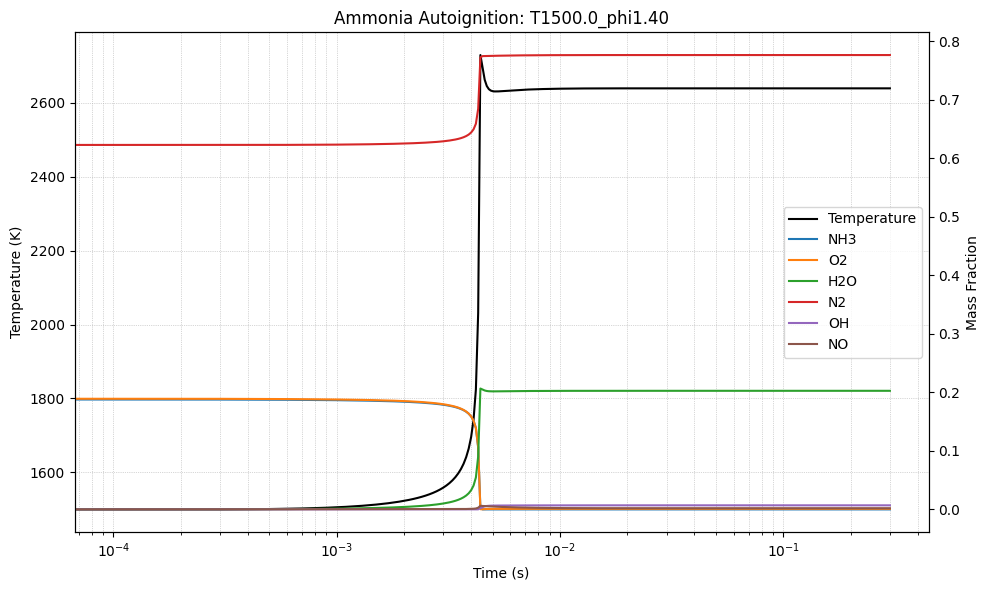

In [4]:
# Visualise the Cantera Simualation Dataset 

# --- Configuration ---
# 1. Set the path to your data folder
DATA_FOLDER = 'Cantera_Dataset' # Or '/content/drive/MyDrive/SciML_Project_Data' on Colab

# 2. Set the specific file you want to plot
# (Change this to any file you generated)
FILENAME = 'data_T1500.0_phi1.40.csv'

# 3. List the species you want to see
# (Temperature is handled separately)
SPECIES_TO_PLOT = [
    'NH3',   # Fuel
    'O2',    # Oxidizer
    'H2O',   # Product
    'N2',    # Product
    'OH',    # Key radical for ignition
    'NO'     # Key nitrogen species
]
# ---------------------

# --- Load the Data ---
file_path = os.path.join(DATA_FOLDER, FILENAME)
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please check your DATA_FOLDER and FILENAME variables.")
    # Stop execution if file isn't found
    raise

# --- Create the Plot ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Temperature on the primary (left) y-axis
color = 'black'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(data['Time (s)'], data['Temperature (K)'], color=color, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(which='both', linestyle=':', linewidth=0.5)

# Set the x-axis to a log scale
ax1.set_xscale('log')

# Create a secondary (right) y-axis for mass fractions
ax2 = ax1.twinx()
ax2.set_ylabel('Mass Fraction')

# Plot all the species on the secondary y-axis
for species in SPECIES_TO_PLOT:
    if species in data.columns:
        ax2.plot(data['Time (s)'], data[species], label=species)
    else:
        print(f"Warning: Species '{species}' not found in data, skipping.")

# --- Create a Combined Legend ---
# (Legends from two axes can be tricky, this is a clean way)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Set the title based on the filename
title_name = FILENAME.replace('.csv', '').replace('data_', '')
plt.title(f'Ammonia Autoignition: {title_name}')

fig.tight_layout()  # Adjust plot to prevent label overlap
plt.show()